# Quantum state tomography (QST) with Gradient descent (GD) 


## Using the method of Cholesky rank


## Note 1:

For the GD methods it is necesary the library Jax (https://github.com/google/jax). Also QuTip is a very important library.

In [1]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library 
import os


from qutip import *
from itertools import *
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qtp
#from qutip import basis, tensor

# Libraries for the different methods of doing QST with GD
from qst_tec.gdchol_rank import gd_chol_rank

import jax
import jax.numpy as jnp
import jax.numpy.linalg  as nlg
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
from jax import config
config.update("jax_enable_x64", True) # We want float64 for better precision
import optax

from tqdm.auto import tqdm   # For the progressbars
import time

/home/mstorresh/anaconda3/envs/gd_qst_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First we will define the number of qubits and the measurement operators. We will use the Pauli matrices.

In [2]:
number_qubits: int = 3
dimension: int = 2**number_qubits
HS: int = dimension


# Creating the Measurement operators (Pauli matrices)

pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
pauli_sys = [tensor(*op) for op in product(pauli, repeat=number_qubits)] # using itertools

Measu_ope = [Qobj(pauli_sys[i], dims=([[2**number_qubits], [2**number_qubits]])) for i in range(len(pauli_sys))]

print(Measu_ope[1:3])

#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]], Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]]]


## The ansatz

We need to create an ansatz that is a matrix with shape $\text{rank}\times\text{dimension}$ and the entries are random complex numbers. e.g. the case of 2 qubits with rank 3: 

$$T_{rank} =  \begin{pmatrix}
a_1 & a_2 & a_3 & a_4 \\
b_1 & b_2 & b_3 & b_4 \\
c_1 & c_2 & c_3 & c_4
\end{pmatrix} $$

In [3]:
def ansatz(kn: int):
    """
    Creates the proper ansatz structure for the different GD methods
    
    Args: 
        kn (int) : rank number
    
    Output:
        T_rank : Ansatz GD-Cholesky rank
        T_rank : Ansatz GD-Cholesky rank
        column_ket_pro : Ansatz GD-manifold
        ket_f, prob1_array_jnp : Ansatz GD-projective 
        
    """
    
    # T_rank  = arbitrary r x p matrix ansatz for Cholesky
    real_part = np.random.rand(kn, dimension)  # Random numbers from a uniform distribution over [0, 1)
    imaginary_part = np.random.rand(kn, dimension)  # Same for the imaginary part
    guess = real_part + 1j * imaginary_part
    T_rank = jnp.asarray(guess)
    
    return T_rank

Visualizing the ansatz with rank 2 (optional)

In [4]:
print(ansatz(2))

[[0.04954341+0.57681827j 0.17977004+0.39642881j 0.62560164+0.24932521j
  0.13478457+0.73664287j 0.97600916+0.79918487j 0.18280434+0.03072511j
  0.42138397+0.44709237j 0.63096686+0.93932197j]
 [0.68160693+0.87933498j 0.98285808+0.17220302j 0.65565487+0.74507314j
  0.39118007+0.89572726j 0.01308485+0.14859976j 0.99108385+0.5289067j
  0.12026598+0.35644136j 0.76233389+0.97579827j]]


## Implementing GD

For the case of a random density matrix for 3 qubits as the original density matrix (the one we want to reconstruct) created with QuTip $\rho_{random}$

In [5]:
fid_list_chol_rank = []
time_list_chol_rank = []


max_itera: int = 300
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 

# The for is to run all the methods multiple times, and then have an average 

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = rand_dm(2**number_qubits)
data = qtp.expect(Measu_ope,rho_or)

##-----------------GD-QST starts ---------------
# define rank of ansatz
rank = 2**number_qubits # maximum rank is 2**N
T_rank = ansatz(rank)

# ..........................................................................
# GD-QST-Cholesky-Rank 
    
rho_gd_chol_rank, f_gd_chol_rank, t_gd_chol_rank, _ = gd_chol_rank(data, rho_or, ops_jnp, T_rank, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
fid_list_chol_rank.append(f_gd_chol_rank)
time_list_chol_rank.append(t_gd_chol_rank)


Fidelity GD-chol-rank 0.9998: 100%|██████████| 300/300 [00:01<00:00, 194.71it/s]


## Plotting the fidelities 


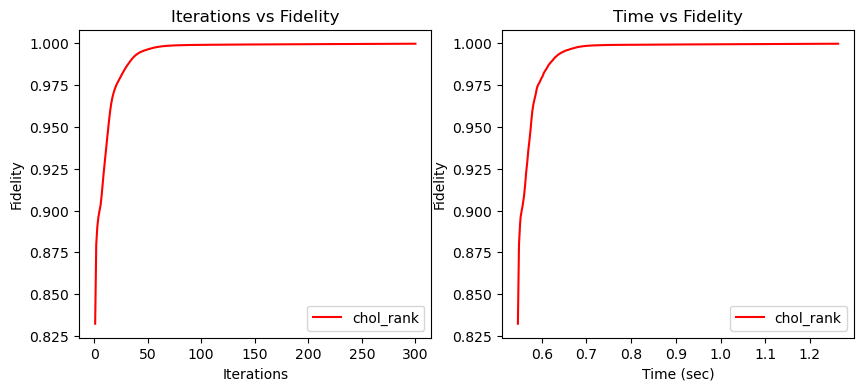

In [6]:
# Transforming to a np arrays and in the case of have more than 1 run the average
fid_list_chol_rank = np.array(fid_list_chol_rank)
mean_fid_chol_rank = np.mean(fid_list_chol_rank, axis=0)
time_list_chol_rank = np.array(time_list_chol_rank)
mean_time_chol_rank = np.mean(time_list_chol_rank, axis=0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_chol_rank)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_chol_rank, color='red',label="chol_rank")


ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_chol_rank, mean_fid_chol_rank, color='red',label="chol_rank")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()

In [7]:
print('max fidelity (chol_rank) and time in seconds:', [np.max(f_gd_chol_rank), mean_time_chol_rank[np.argmax(mean_fid_chol_rank)]])


max fidelity (chol_rank) and time in seconds: [0.9997788297640204, 1.2629785537719727]


## GHZ state
Now let's reconstruct a GHZ state
$$ \frac{|000\rangle + |111\rangle}{\sqrt{2}}$$

In [8]:
# Define the basis states |0> and |1> for a single qubit
zero = qtp.basis(2, 0)  # |0>
one = qtp.basis(2, 1)   # |1>

# Construct the |000> and |111> states for 3 qubits
state_000 = qtp.tensor(zero, zero, zero)  # |000>
state_111 = qtp.tensor(one, one, one)     # |111>

# Create the GHZ state: (|000> + |111>) / sqrt(2)
ghz_state = (state_000 + state_111).unit()
ghz_state = qtp.Qobj(ghz_state.full(), dims=[[8], [1]])  # Reshape the GHZ state to have dimensions [8]
# This reshape is necessary for the function qtp.expect. It will depend of the version of QuTip
 
print(ghz_state)

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket'
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [9]:
fid_list_chol_rank = []
time_list_chol_rank = []


max_itera: int = 300
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 

# The for is to run all the methods multiple times, and then have an average 

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = ghz_state
data = qtp.expect(Measu_ope,rho_or)

##-----------------GD-QST starts ---------------
# define rank of ansatz
rank = 1 # maximum rank is 2**N
T_rank = ansatz(rank)

# ..........................................................................
# GD-QST-Cholesky-Rank 
    
rho_gd_chol_rank, f_gd_chol_rank, t_gd_chol_rank, _ = gd_chol_rank(data, rho_or, ops_jnp, T_rank, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
fid_list_chol_rank.append(f_gd_chol_rank)
time_list_chol_rank.append(t_gd_chol_rank)

  0%|          | 0/300 [00:00<?, ?it/s]

Fidelity GD-chol-rank 1.0000: 100%|██████████| 300/300 [00:01<00:00, 259.17it/s]


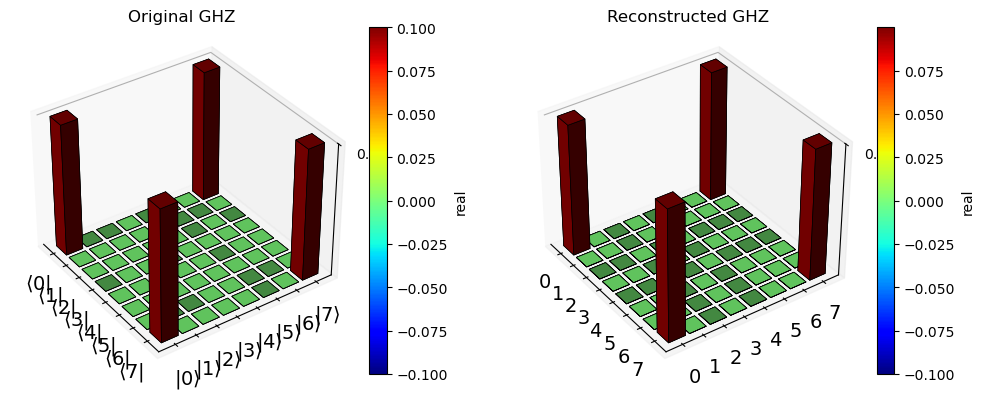

In [10]:
rho_ghz = tensor(ghz_state, ghz_state.dag())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": "3d"})

# Plot the first matrix histogram
matrix_histogram(rho_ghz, ax=axes[0])
axes[0].set_title("Original GHZ")

# Plot the second matrix histogram
matrix_histogram(rho_gd_chol_rank, ax=axes[1])
axes[1].set_title("Reconstructed GHZ")

# Show the plots
plt.show()

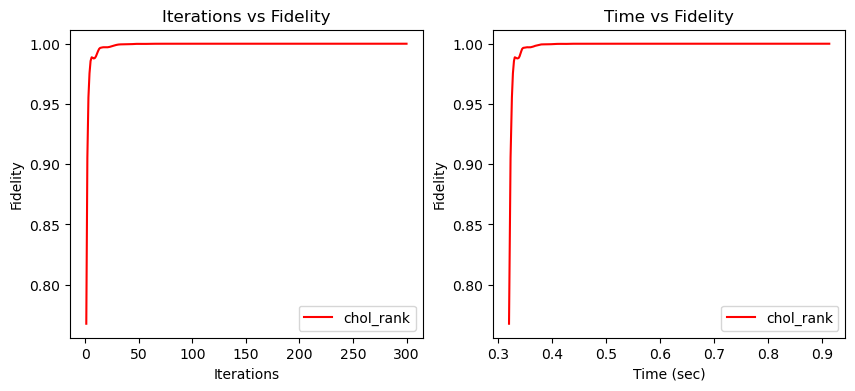

In [11]:
# Transforming to a np arrays and in the case of have more than 1 run the average
fid_list_chol_rank = np.array(fid_list_chol_rank)
mean_fid_chol_rank = np.mean(fid_list_chol_rank, axis=0)
time_list_chol_rank = np.array(time_list_chol_rank)
mean_time_chol_rank = np.mean(time_list_chol_rank, axis=0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_chol_rank)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_chol_rank, color='red',label="chol_rank")


ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_chol_rank, mean_fid_chol_rank, color='red',label="chol_rank")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()